In [1]:
import ee
import geemap
ee.Initialize(project='ee-zcs')
import geopandas as gpd
import pandas as pd
import numpy as np


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [ ]:
# ...existing code...
import geopandas as gpd
import fiona
file = '/usr2/postdoc/chishan/project_data/CODF/CODF_Chishan.gpkg'

# robustly list layers
try:
    layers = fiona.listlayers(file)
except Exception:
    # fallback if fiona is not available in this import path
    try:
        layers = gpd.io.file.fiona.listlayers(file)  # may be None in some installs
    except Exception:
        layers = None

print("Layers in the geopackage:", layers)

# read layer: prefer explicit name if known, otherwise read first available layer
if layers:
    layer_to_read = 'CODF_Chishan' if 'CODF_Chishan' in layers else layers[0]
else:
    layer_to_read = None

if layer_to_read:
    gdf = gpd.read_file(file, layer=layer_to_read)
else:
    # read_file without layer may work for single-layer gpkg
    gdf = gpd.read_file(file)

gdf = gdf.to_crs(epsg=4326)
print(f"Read layer: {layer_to_read}, rows: {len(gdf)}")
print(gdf.head())
# ...existing code...


Layers in the geopackage: ['CODF_all_lines', 'CODF_all_points', 'CODF_all_polygons', 'CODF_high_lines', 'CODF_high_points', 'CODF_high_polygons', 'site_categories', 'CODF_info', 'Loans', 'Lenders', 'Borrowers', 'Countries', 'Sources', 'Geolocation', 'Facilities', 'SubSectors', 'Sectors', 'FOREX', 'Project_Status', 'Loan_Types', 'Definitions', 'Disbursement_Status', 'Dataset-2025-EN']
Read layer: CODF_all_lines, rows: 443
       BU ID  Type  Level of p  \
0  AO.009.34  Line           1   
1  AO.009.36  Line           1   
2  AO.009.39  Line           1   
3  AO.009.40  Line           1   
4  AO.009.42  Line           1   

                                            geometry  
0  MULTILINESTRING ((12.36948 -6.1316, 12.37329 -...  
1  MULTILINESTRING ((12.85618 -7.20366, 12.85513 ...  
2  MULTILINESTRING ((13.23018 -8.81466, 13.2304 -...  
3  MULTILINESTRING ((13.6345 -8.50142, 13.63363 -...  
4  MULTILINESTRING ((12.84941 -6.90978, 12.84962 ...  


In [ ]:
gdf_sector= gpd.read_file(file,layer='Dataset-2025-EN')
# gdf_sector = gdf_sector.to_crs(epsg=4326)
print(gdf_sector.head())


       BU ID                                       Project name     Country  \
0     AR.005                       Cauchari Solar Plant (210MW)   Argentina   
1     MN.001       Zamyn-Uud Infrastructure Improvement Project    Mongolia   
2  KZ.013.03  KazMunayGas Atyrau Refinery Advanced Oil Refin...  Kazakhstan   
3     MV.004                   China Maldives Friendship Bridge    Maldives   
4  BD.007.01  Single Point Mooring, Double Pipelines (Prefer...  Bangladesh   

                            Region                              Borrower  \
0  Latin America and the Caribbean                   National Government   
1                             Asia                   National Government   
2                             Asia  Development Bank of Kazakhstan (DBK)   
3                             Asia                   National Government   
4                             Asia                   National Government   

   Lender  Loan Sign Year Loan Amount (USD M)                       

## export

In [16]:
%run /usr2/postdoc/chishan/research/CODF/20250916_protectedArea.py


Combined CODF FeatureCollection: 743
Starting forest loss analysis with protection area overlay...
Creating protected/non-protected geometry splits...
Processing 5.0km buffer...


EEException: Invalid GeoJSON geometry.

In [18]:
"""
Hansen Global Forest Change Analysis with Protected Areas Overlay

Purpose: Analyze forest cover change (2001-2024) within and outside protected areas for CODF investment sites,
providing separate statistics for protected and non-protected portions at multiple buffer distances.

Inputs:
- CODF investment sites (filtered_CODF_polygons FeatureCollection)
- Hansen Global Forest Change v1.12 dataset
- WCMC World Database on Protected Areas

Outputs:
- CSV file with annual and cumulative forest loss metrics by protection status
- Time series data (2001-2024) for each site/buffer/protection combination

Time window: 2001-2024 (Hansen forest loss), 2000 baseline forest cover
"""

import ee
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Initialize Google Earth Engine
ee.Initialize(project='ee-zcs')

# ============================================================================
# DATA PREPARATION
# ============================================================================

# 假设您已经有了filtered_CODF_polygons
# filtered_CODF_polygons = ee.FeatureCollection("your_filtered_codf_polygons")

# Load WCMC Protected Areas
wcmc_protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')

# Load Hansen Global Forest Change dataset
HANSEN = ee.Image("UMD/hansen/global_forest_change_2024_v1_12")

# Buffer distances (meters)
buffers = [5000, 10000, 15000, 20000, 25000, 50000]

# ============================================================================
# GEOMETRY PROCESSING FUNCTIONS
# ============================================================================

def create_protected_non_protected_splits(feature_collection, buffer_distances):
    """
    Split each buffered feature into protected and non-protected portions
    
    Args:
        feature_collection: CODF features
        buffer_distances: List of buffer distances in meters
    
    Returns:
        Dictionary with protected and non-protected feature collections for each buffer
    """
    
    results = {}
    
    for buffer_dist in buffer_distances:
        print(f"Processing {buffer_dist/1000}km buffer...")
        
        # Create buffered features
        def create_buffer(feature):
            return (feature.buffer(buffer_dist)
                   .set('buffer_dist', buffer_dist)
                   .set('buffer_km', buffer_dist/1000)
                   .set('original_id', feature.get('BU_ID'))
                   .copyProperties(feature))
        
        buffered_features = feature_collection.map(create_buffer)
        
        # Create protected and non-protected portions for each feature
        def split_by_protection_status(feature):
            # Get the buffered geometry
            buffered_geom = feature.geometry()
            
            # Find intersecting protected areas
            intersecting_pas = wcmc_protected_areas.filterBounds(buffered_geom)
            
            # Handle case where no protected areas intersect
            def create_protected_portion():
                pas_union = intersecting_pas.geometry().dissolve()
                return buffered_geom.intersection(pas_union, ee.ErrorMargin(1))
            
            def create_empty_protected_portion():
                return ee.Geometry.Polygon([[[0, 0], [0, 0], [0, 0], [0, 0]]])
            
            # Calculate protected portion conditionally
            protected_portion = ee.Algorithms.If(
                intersecting_pas.size().gt(0),
                create_protected_portion(),
                create_empty_protected_portion()
            )
            
            # Handle non-protected portion
            def create_non_protected_portion():
                pas_union = intersecting_pas.geometry().dissolve()
                return buffered_geom.difference(pas_union, ee.ErrorMargin(1))
            
            def use_full_buffer():
                return buffered_geom
            
            # Calculate non-protected portion conditionally
            non_protected_portion = ee.Algorithms.If(
                intersecting_pas.size().gt(0),
                create_non_protected_portion(),
                use_full_buffer()
            )
            
            # Create protected feature
            protected_feature = ee.Feature(
                ee.Geometry(protected_portion),
                feature.toDictionary().combine(ee.Dictionary({
                    'protection_status': 'protected',
                    'analysis_type': 'protected_portion',
                    'has_protection': intersecting_pas.size().gt(0)
                }))
            )
            
            # Create non-protected feature
            non_protected_feature = ee.Feature(
                ee.Geometry(non_protected_portion), 
                feature.toDictionary().combine(ee.Dictionary({
                    'protection_status': 'non_protected',
                    'analysis_type': 'non_protected_portion',
                    'has_protection': intersecting_pas.size().gt(0)
                }))
            )
            
            return ee.FeatureCollection([protected_feature, non_protected_feature])
        
        # Apply splitting to all features and flatten
        split_features = buffered_features.map(split_by_protection_status).flatten()
        
        # Separate into protected and non-protected collections
        # Filter out features with empty geometries
        protected_features = split_features.filter(
            ee.Filter.And(
                ee.Filter.eq('protection_status', 'protected'),
                ee.Filter.eq('has_protection', True)
            )
        )
        non_protected_features = split_features.filter(ee.Filter.eq('protection_status', 'non_protected'))
        
        results[buffer_dist] = {
            'protected': protected_features,
            'non_protected': non_protected_features,
            'combined': split_features
        }
    
    return results

# ============================================================================
# HANSEN DATA PROCESSING
# ============================================================================

# Extract Hansen components
treecover2000 = HANSEN.select('treecover2000')
lossyear = HANSEN.select('lossyear')
datamask = HANSEN.select('datamask')

# Define analysis parameters
analysis_start_year = 2001
analysis_end_year = 2024
forest_threshold = 30  # 30% tree cover threshold

# Create initial forest mask (year 2000, >=30% tree cover)
initial_forest_2000 = treecover2000.gte(forest_threshold).And(datamask.eq(1))

def create_hansen_annual_deforestation():
    """Create annual deforestation images (2001-2024)"""
    
    annual_deforestation_images = []
    
    for year in range(analysis_start_year, analysis_end_year + 1):
        # Hansen uses year codes (1 = 2001, 2 = 2002, etc.)
        hansen_year_code = year - 2000
        
        # Deforestation in this year = was forest in 2000 AND lost in this year
        annual_defor = initial_forest_2000.And(lossyear.eq(hansen_year_code))
        annual_deforestation_images.append(
            annual_defor.rename(f'hansen_defor_{year}')
        )
    
    return ee.Image.cat(annual_deforestation_images)

# Create the Hansen annual deforestation stack
hansen_annual_deforestation = create_hansen_annual_deforestation()

# ============================================================================
# FOREST LOSS CALCULATION FUNCTIONS
# ============================================================================

def calculate_forest_loss_metrics(feature_collection, buffer_dist, protection_status):
    """
    Calculate annual forest loss metrics for a feature collection
    
    Args:
        feature_collection: Features to analyze
        buffer_dist: Buffer distance in meters
        protection_status: 'protected', 'non_protected', or 'combined'
    
    Returns:
        Feature collection with calculated metrics
    """
    
    # Calculate area for each annual deforestation band
    defor_area_stack = hansen_annual_deforestation.multiply(ee.Image.pixelArea())
    
    # Also calculate initial forest area
    initial_forest_area = initial_forest_2000.multiply(ee.Image.pixelArea())
    
    def process_feature(f):
        # Calculate initial forest area
        initial_forest_ha = ee.Number(f.get('initial_forest_2000')).divide(10000)
        
        # Get all the annual deforestation areas
        annual_stats = {}
        total_deforestation = 0
        
        for year in range(analysis_start_year, analysis_end_year + 1):
            band_name = f'hansen_defor_{year}'
            area_m2 = ee.Number(f.get(band_name))
            area_ha = area_m2.divide(10000)
            annual_stats[f'hansen_defor_{year}_ha'] = area_ha
            total_deforestation = ee.Number(total_deforestation).add(area_ha)
        
        # Calculate forest loss rate (total deforestation / initial forest area)
        forest_loss_rate = ee.Number(
            ee.Algorithms.If(
                initial_forest_ha.gt(0),
                total_deforestation.divide(initial_forest_ha).multiply(100),
                0
            )
        )
        
        # Calculate annual average loss rate
        years_analyzed = analysis_end_year - analysis_start_year + 1
        annual_avg_loss_rate = forest_loss_rate.divide(years_analyzed)
        
        # Set all properties
        base_properties = {
            'BU_ID': f.get('BU_ID'),
            'original_id': f.get('original_id'), 
            'buffer_dist': buffer_dist,
            'buffer_km': buffer_dist/1000,
            'protection_status': protection_status,
            'analysis_type': f.get('analysis_type'),
            'initial_forest_2000_ha': initial_forest_ha,
            'total_deforestation_2001_2024_ha': total_deforestation,
            'forest_loss_rate_percent': forest_loss_rate,
            'annual_avg_loss_rate_percent': annual_avg_loss_rate,
            'analysis_period': f'{analysis_start_year}-{analysis_end_year}',
            'forest_threshold_percent': forest_threshold,
            'dataset': 'Hansen_GFC_v1_12'
        }
        
        # Combine base properties with annual stats
        all_properties = {**base_properties, **annual_stats}
        
        return ee.Feature(None, all_properties)
    
    # Combine deforestation stack with initial forest
    combined_stack = defor_area_stack.addBands(initial_forest_area.rename('initial_forest_2000'))
    
    # Calculate statistics
    stats = (combined_stack.reduceRegions(
        collection=feature_collection,
        reducer=ee.Reducer.sum(),
        scale=30,
        crs='EPSG:4326'
    ).map(process_feature))
    
    return stats

# ============================================================================
# EXPORT FUNCTIONS
# ============================================================================

def export_forest_analysis_with_protection_status(filtered_codf_polygons):
    """
    Main function to analyze forest loss with protection status overlay
    
    Args:
        filtered_codf_polygons: Your filtered CODF polygon collection
    """
    
    print("Starting forest loss analysis with protection area overlay...")
    
    # Step 1: Create protected/non-protected splits for all buffer distances
    print("Creating protected/non-protected geometry splits...")
    split_results = create_protected_non_protected_splits(filtered_codf_polygons, buffers)
    
    # Step 2: Calculate forest loss metrics for each buffer and protection status
    print("Calculating forest loss metrics...")
    
    all_results = []
    
    for buffer_dist in buffers:
        print(f"Processing {buffer_dist/1000}km buffer...")
        
        buffer_data = split_results[buffer_dist]
        
        # Calculate metrics for protected areas
        if buffer_data['protected'].size().getInfo() > 0:
            protected_stats = calculate_forest_loss_metrics(
                buffer_data['protected'], 
                buffer_dist, 
                'protected'
            )
            all_results.append(('protected', buffer_dist, protected_stats))
        
        # Calculate metrics for non-protected areas  
        if buffer_data['non_protected'].size().getInfo() > 0:
            non_protected_stats = calculate_forest_loss_metrics(
                buffer_data['non_protected'],
                buffer_dist, 
                'non_protected'
            )
            all_results.append(('non_protected', buffer_dist, non_protected_stats))
    
    # Step 3: Export results
    print("Exporting results...")
    
    for protection_status, buffer_dist, stats in all_results:
        task = ee.batch.Export.table.toDrive(
            collection=stats,
            description=f'hansen_forest_loss_{protection_status}_buffer_{buffer_dist/1000}km_2001_2024',
            fileFormat='CSV',
            folder='hansenProtectionAnalysis'
        )
        task.start()
        print(f"Export task started: {protection_status} areas, {buffer_dist/1000}km buffer")
    
    # Also export a combined dataset
    if all_results:
        combined_stats = ee.FeatureCollection([result[2] for result in all_results]).flatten()
        
        combined_task = ee.batch.Export.table.toDrive(
            collection=combined_stats,
            description=f'hansen_forest_loss_combined_protection_analysis_2001_2024',
            fileFormat='CSV', 
            folder='hansenProtectionAnalysis'
        )
        combined_task.start()
        print("Combined export task started")
    
    print("All export tasks initiated!")
    print(f"Check the 'hansenProtectionAnalysis' folder in your Google Drive")
    print(f"Total export tasks: {len(all_results) + 1}")

# ============================================================================
# EXECUTION
# ============================================================================
# read the saved file
availability_threshold = 90  # Set your threshold here
output_file = f'/usr2/postdoc/chishan/project_data/CODF/tmf_suitable_sites_90percent.csv'

good_sites = pd.read_csv(output_file)

# Load all CODF datasets - points, lines, and polygons
HANSEN = ee.Image("UMD/hansen/global_forest_change_2024_v1_12")
CODF_polygons = ee.FeatureCollection("projects/ee-zcs/assets/CODF_polygons")
CODF_points = ee.FeatureCollection("projects/ee-zcs/assets/CODF_points")
CODF_lines = ee.FeatureCollection("projects/ee-zcs/assets/CODF_lines")

#combine all CODF datasets into a single FeatureCollection
CODF_combined = CODF_polygons.merge(CODF_lines)
print("Combined CODF FeatureCollection:", CODF_combined.size().getInfo())

#filter good sites based on the availability threshold
filtered_CODF_polygons = CODF_combined.filter(ee.Filter.inList('BU ID', good_sites['BU_ID'].tolist()))

# 运行分析 - 请确保您的 filtered_CODF_polygons 变量已定义
export_forest_analysis_with_protection_status(filtered_CODF_polygons)

print("Forest analysis script loaded successfully!")
print("To run the analysis, call: export_forest_analysis_with_protection_status(your_filtered_CODF_polygons)")
print("\nThis script will:")
print("1. Split each CODF feature buffer into protected and non-protected portions")
print("2. Calculate annual forest loss (2001-2024) for each portion separately") 
print("3. Calculate forest loss rates and annual averages")
print("4. Export results to CSV files in 'hansenProtectionAnalysis' folder")
print("5. Include both separate files by protection status and a combined file")


Combined CODF FeatureCollection: 743
Starting forest loss analysis with protection area overlay...
Creating protected/non-protected geometry splits...
Processing 5.0km buffer...
Processing 10.0km buffer...
Processing 15.0km buffer...
Processing 20.0km buffer...
Processing 25.0km buffer...
Processing 50.0km buffer...
Calculating forest loss metrics...
Processing 5.0km buffer...
Processing 10.0km buffer...
Processing 15.0km buffer...
Processing 20.0km buffer...
Processing 25.0km buffer...
Processing 50.0km buffer...
Exporting results...
Export task started: non_protected areas, 5.0km buffer
Export task started: non_protected areas, 10.0km buffer
Export task started: non_protected areas, 15.0km buffer
Export task started: non_protected areas, 20.0km buffer
Export task started: non_protected areas, 25.0km buffer
Export task started: non_protected areas, 50.0km buffer
Combined export task started
All export tasks initiated!
Check the 'hansenProtectionAnalysis' folder in your Google Drive
To

In [26]:
ee.Authenticate()



Successfully saved authorization token.


In [36]:
%run /usr2/postdoc/chishan/research/CODF/20250916_protectedArea3.py


Creating protected areas mask at 30m resolution...
Creating masked forest datasets...
=== Masked Forest Analysis Script Loaded ===
This approach uses rasterized WCMC masks to avoid geometry operations!

Recommended debugging steps:
1. Check field names: debug_field_names(your_data)
2. Test BU_ID transfer: test_bu_id_transfer(your_data)
3. Test mask: test_protected_mask()
4. Test single site: test_single_site_masked(your_data)
5. Run full analysis: export_masked_forest_analysis(your_data)

TileScale parameters:
- tileScale=1: Full resolution (may cause memory errors)
- tileScale=2: Half resolution (recommended)
- tileScale=4: Quarter resolution (for large areas)
- tileScale=8+: Lower resolution (for memory issues)

=== Local Data Combination (after download) ===
import pandas as pd
import glob

# Read protected files
protected_files = glob.glob('forest_PROTECTED_mask_*km_2001_2024.csv')
protected_df = pd.concat([pd.read_csv(f) for f in protected_files], ignore_index=True)

# Read non-pr

In [ ]:
# After downloading CSV files, combine them locally:
import pandas as pd
import glob

# Read all protected files
protected_files = glob.glob('forest_loss_PROTECTED_*km_2001_2024.csv')
protected_dfs = [pd.read_csv(f) for f in protected_files]
protected_combined = pd.concat(protected_dfs, ignore_index=True)

# Read all non-protected files  
non_protected_files = glob.glob('forest_loss_NON_PROTECTED_*km_2001_2024.csv')
non_protected_dfs = [pd.read_csv(f) for f in non_protected_files] 
non_protected_combined = pd.concat(non_protected_dfs, ignore_index=True)

# Combine everything
all_results = pd.concat([protected_combined, non_protected_combined], ignore_index=True)


## analysis

Forest Analysis and Visualization Script
Usage example:

    # Set your paths
    data_folder = "./forestAnalysisSimple/"  # Folder with CSV files
    shapefile_path = "path/to/your/shapefile.shp"  # Shapefile with sector data
    
    # Run complete analysis
    df_long, df_classified, summary, comparison, pre_post_results = run_complete_analysis(
        data_folder_path=data_folder,
        shapefile_path=shapefile_path,
        buffer_km=10,  # Focus on 10km buffer
        output_folder='./analysis_results/'
    )
    
    # The script will:
    # 1. Load and combine all CSV files
    # 2. Match with sector information and loan sign year using BU ID
    # 3. Calculate annual deforestation rates
    # 4. Classify data into pre-loan and post-loan periods
    # 5. Create comparison plots showing protection effectiveness
    # 6. Generate before/after loan analysis plots for both protected and non-protected areas
    # 7. Show loan impact comparison across protection status
    
=== ST

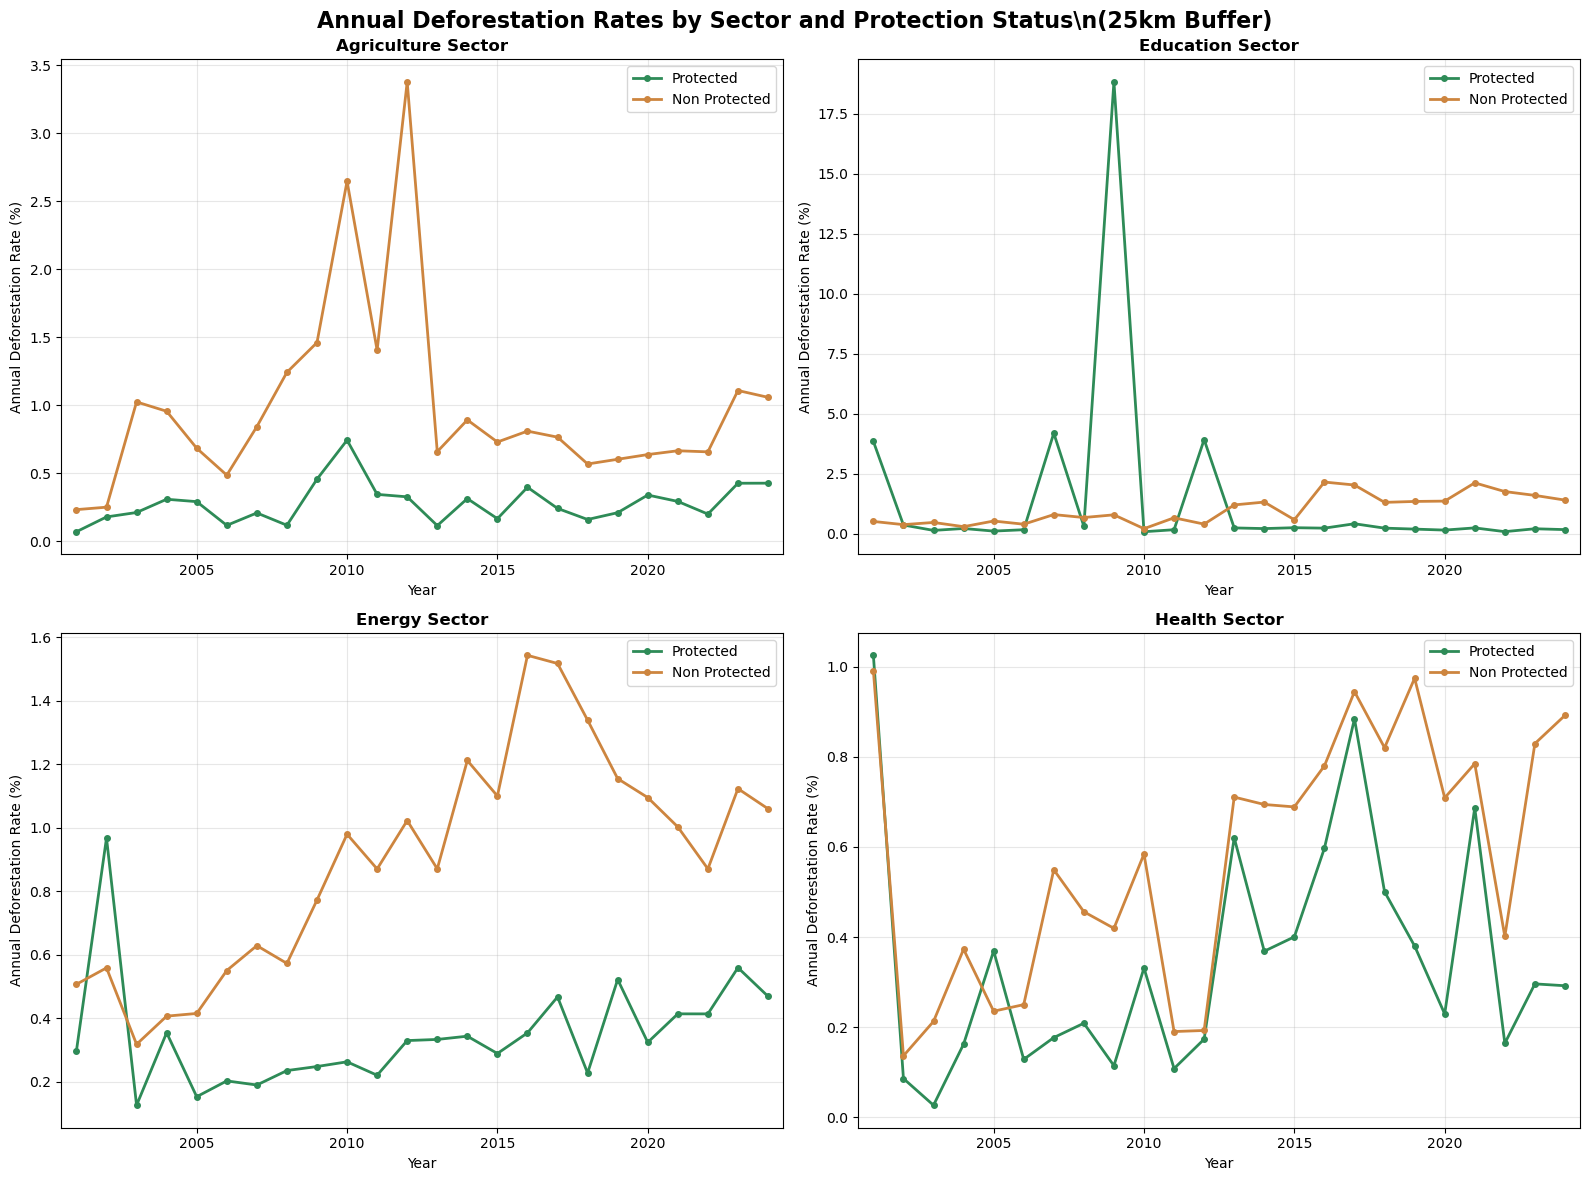

Plot saved to: ./analysis_results//protection_effect_comparison_25km.png


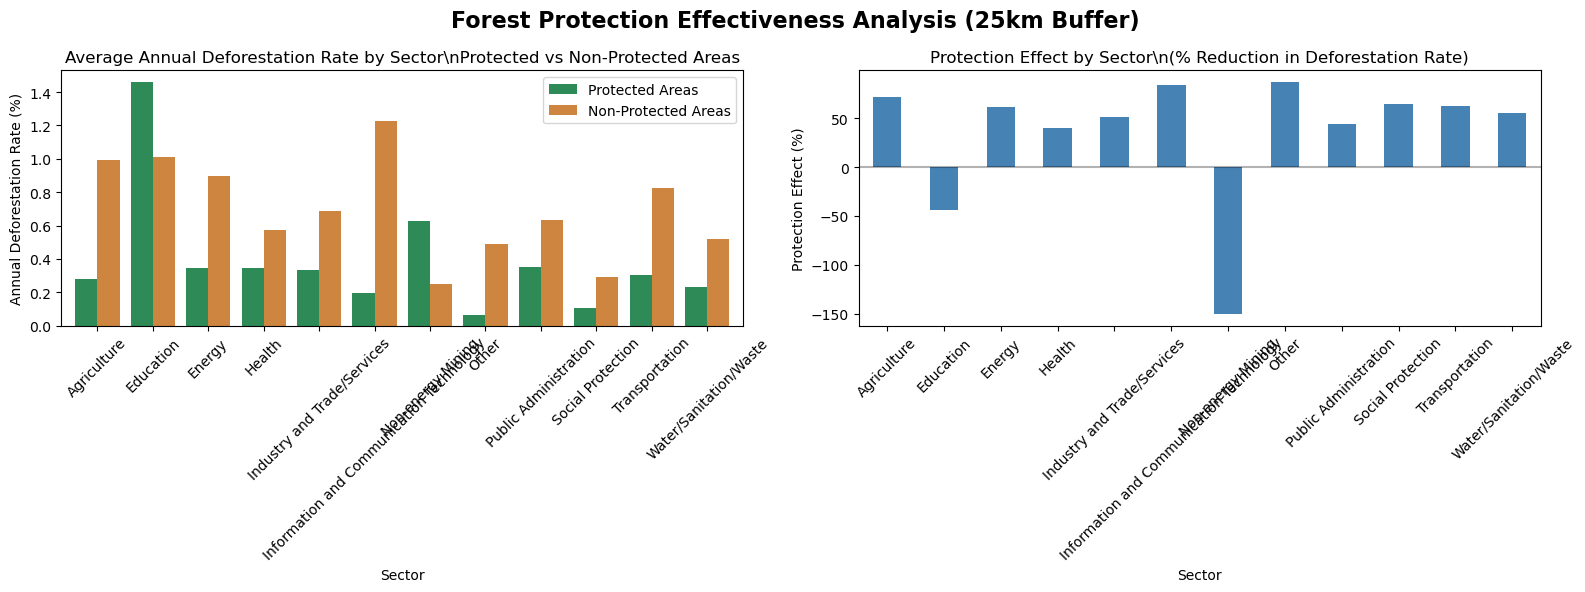

\nCreating before/after loan analysis plots...
Plot saved to: ./analysis_results//loan_impact_protected_areas_25km.png


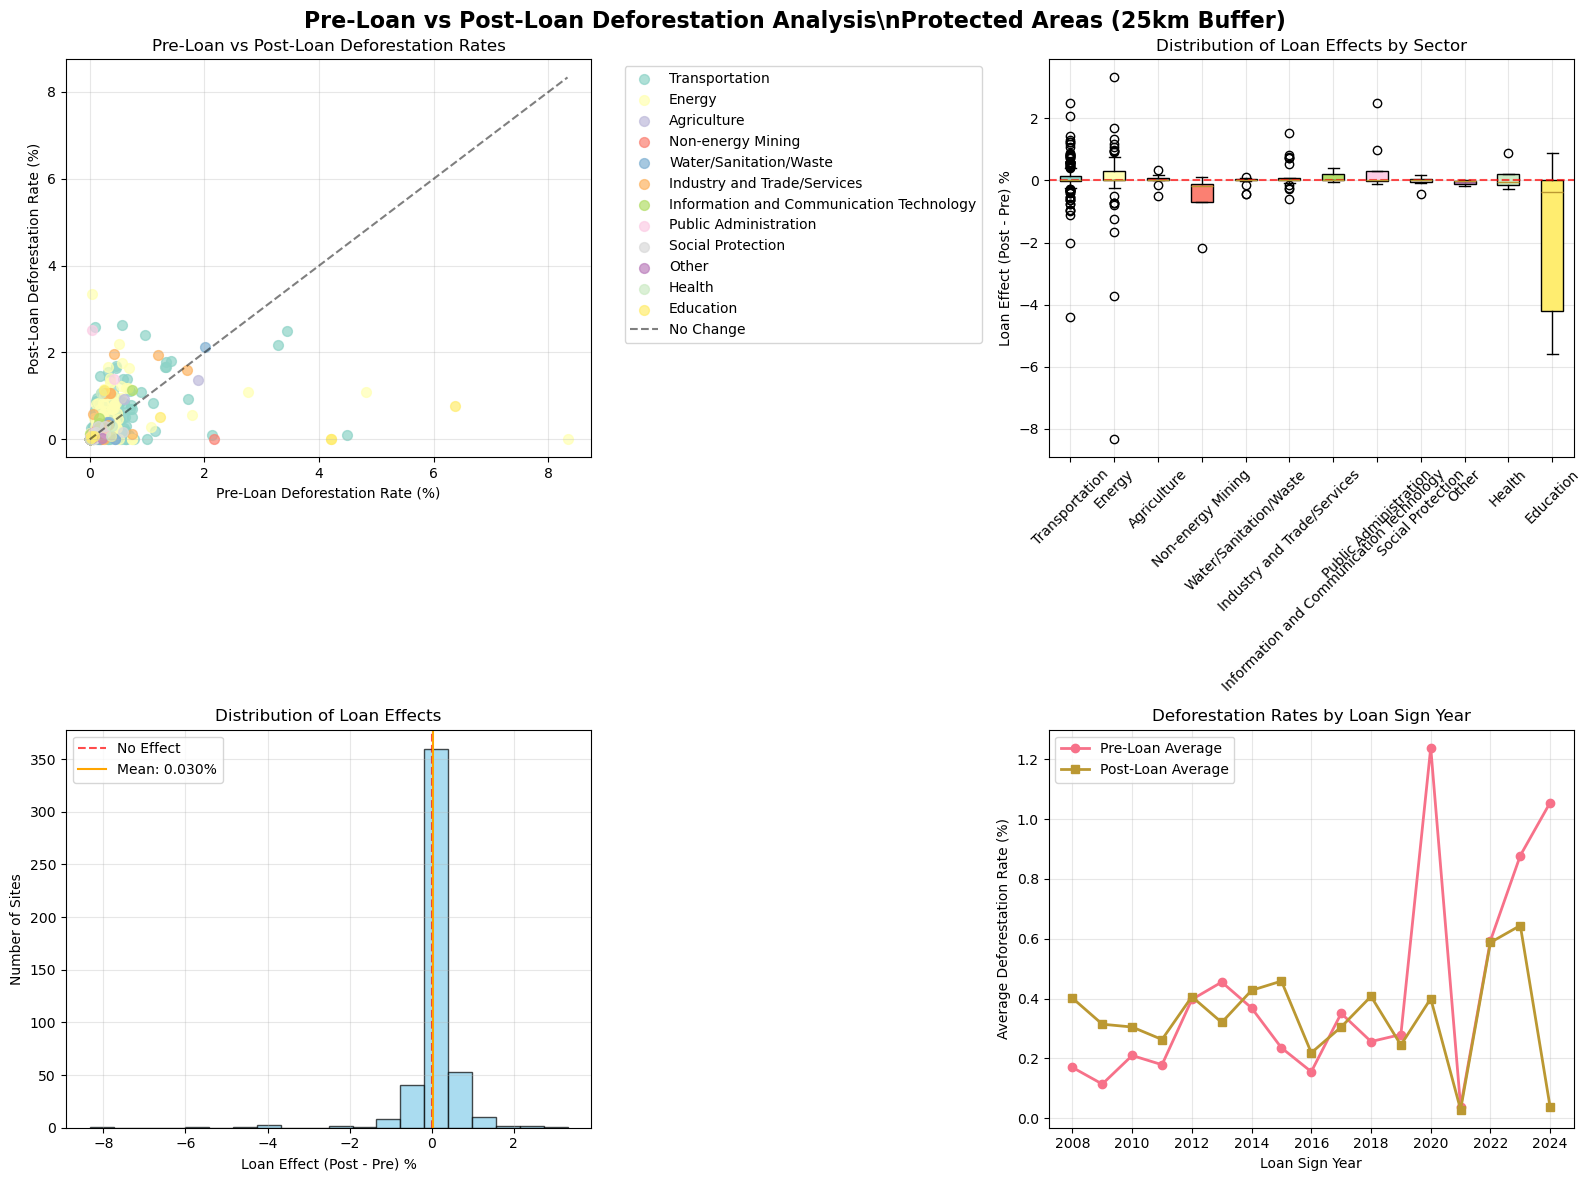

\n=== Protected Areas Summary ===
Number of sites: 486
Mean pre-loan rate: 0.2986%
Mean post-loan rate: 0.3290%
Mean loan effect: 0.0303%
Sites with increased deforestation: 214
Sites with decreased deforestation: 144
Plot saved to: ./analysis_results//loan_impact_non_protected_areas_25km.png


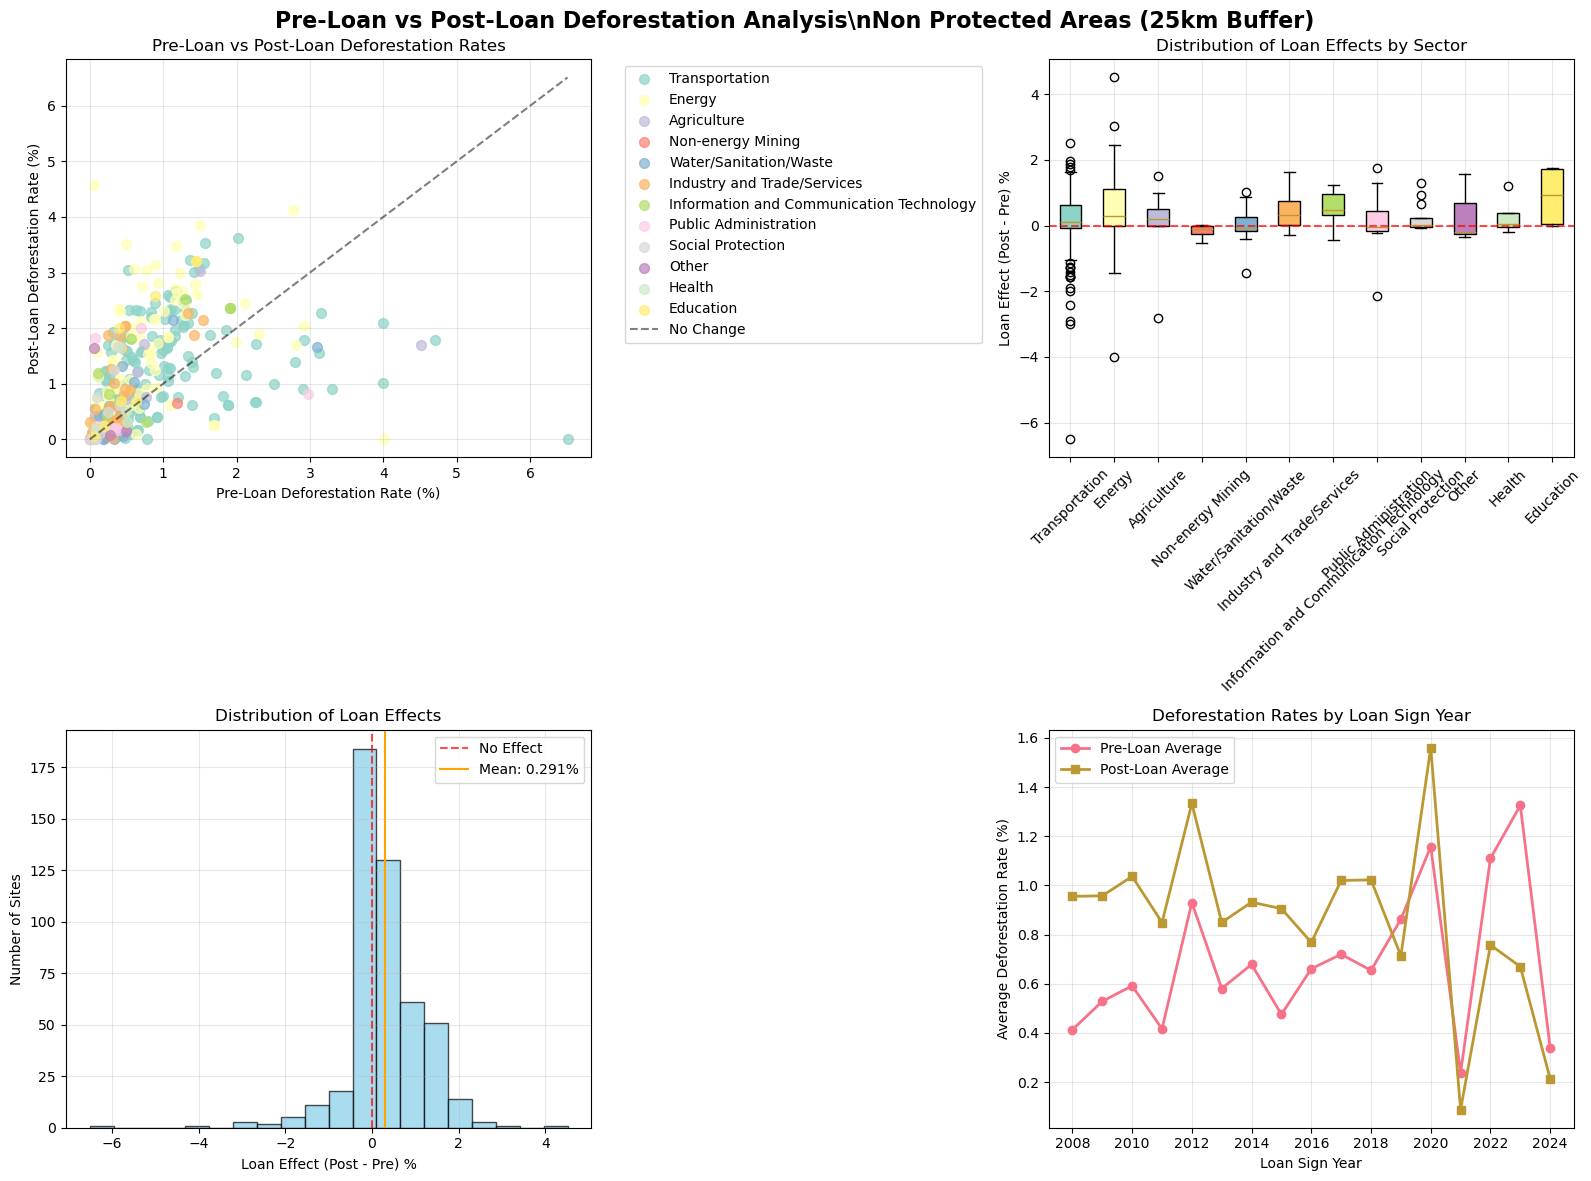

\n=== Non Protected Areas Summary ===
Number of sites: 486
Mean pre-loan rate: 0.6512%
Mean post-loan rate: 0.9427%
Mean loan effect: 0.2914%
Sites with increased deforestation: 323
Sites with decreased deforestation: 155
Plot saved to: ./analysis_results//loan_impact_protection_comparison_all_years_25km.png


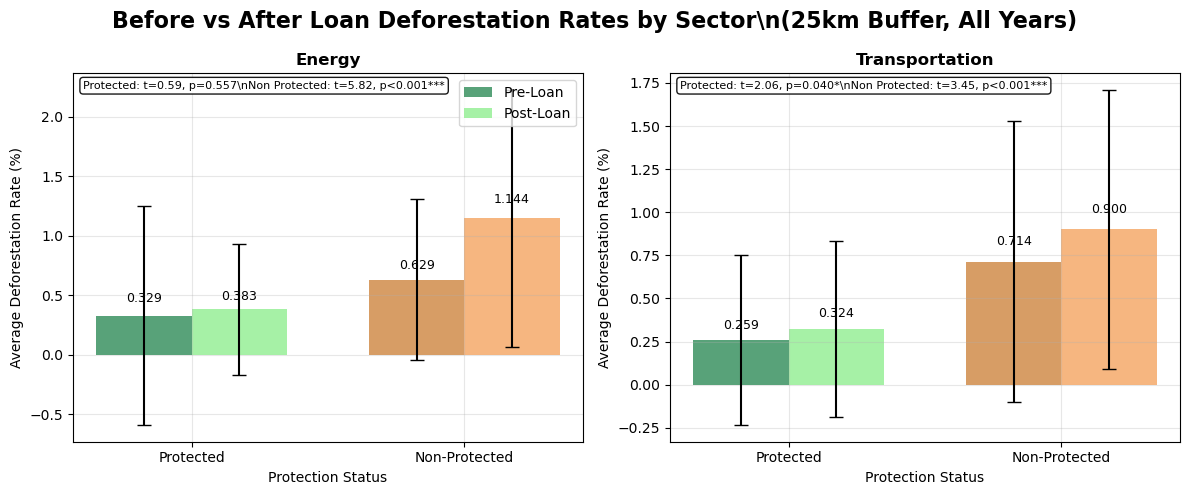

\n=== Paired T-Test Results (Before vs After Loan, All Years) ===
Sector               Protection      n    t_stat   p_value    Pre-Loan   Post-Loan  Difference   Sig  
--------------------------------------------------------------------------------------------------------------
Energy               protected       120  0.589    0.557      0.3289     0.3826     0.0537            
Energy               non_protected   120  5.825    0.000      0.6294     1.1444     0.5149       ***  
Transportation       protected       258  2.060    0.040      0.2591     0.3236     0.0646       *    
Transportation       non_protected   258  3.452    0.001      0.7139     0.9003     0.1865       ***  
\n=== Overall Summary by Protection Status (All Years) ===
\nProtected Areas:
  Total sites: 378
  Mean pre-loan rate: 0.2812% ± 0.6580%
  Mean post-loan rate: 0.3423% ± 0.5229%
  Mean difference (post-pre): 0.0611%
  Overall paired t-test: t=1.702, p=0.090
\nNon Protected Areas:
  Total sites: 378
  Mean p

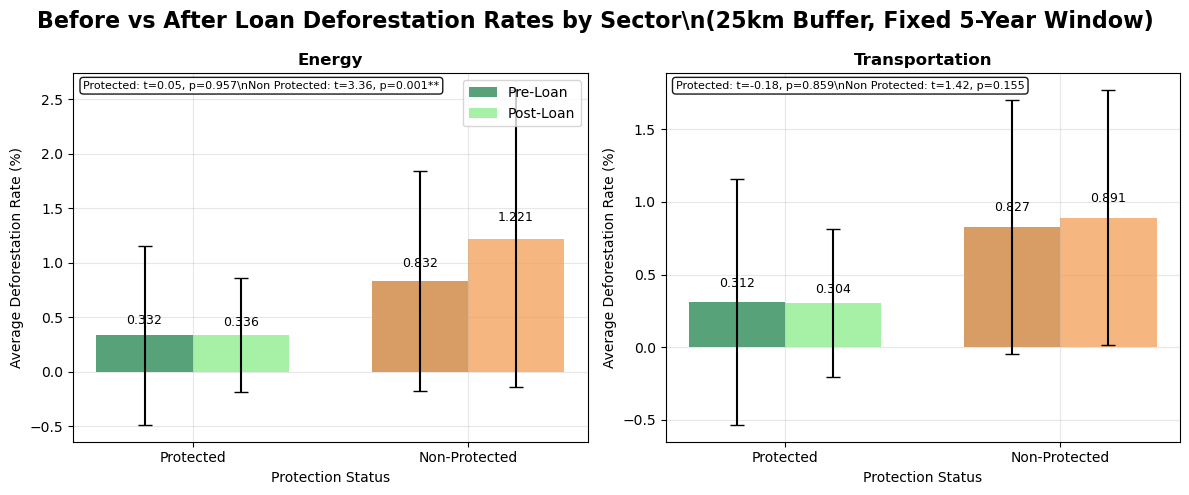

\n=== Paired T-Test Results (Before vs After Loan, Fixed 5-Year Window) ===
Sector               Protection      n    t_stat   p_value    Pre-Loan   Post-Loan  Difference   Sig  
--------------------------------------------------------------------------------------------------------------
Energy               protected       120  0.054    0.957      0.3319     0.3357     0.0038            
Energy               non_protected   120  3.356    0.001      0.8318     1.2213     0.3895       **   
Transportation       protected       256  -0.177   0.859      0.3117     0.3040     -0.0077           
Transportation       non_protected   256  1.425    0.155      0.8266     0.8912     0.0647            
\n=== Overall Summary by Protection Status (Fixed 5-Year Window) ===
\nProtected Areas:
  Total sites: 376
  Mean pre-loan rate: 0.3181% ± 0.8383%
  Mean post-loan rate: 0.3141% ± 0.5156%
  Mean difference (post-pre): -0.0040%
  Overall paired t-test: t=-0.109, p=0.913
\nNon Protected Areas:
  Tot

In [45]:
%run /usr2/postdoc/chishan/research/CODF/20250917_analysis.py


In [22]:
dataset = ee.FeatureCollection('WCMC/WDPA/current/polygons')
visParams = {
  'palette': ['2ed033', '5aff05', '67b9ff', '5844ff', '0a7618', '2c05ff'],
  'min': 0.0,
  'max': 1550000.0,
  'opacity': 0.8,
}
image = ee.Image().float().paint(dataset, 'REP_AREA')
Map.setCenter(41.104, -17.724, 6)
Map.addLayer(image, visParams, 'WCMC/WDPA/current/polygons')
Map.addLayer(dataset, {}, 'for Inspector', False)

# Define CODF_polygons and CODF_lines if not already defined
CODF_polygons = ee.FeatureCollection("projects/ee-zcs/assets/CODF_polygons")
CODF_lines = ee.FeatureCollection("projects/ee-zcs/assets/CODF_lines")

Map.addLayer(CODF_polygons, {}, 'polygons')

codf_polygons_buff = CODF_polygons.map(lambda feature: feature.buffer(25000.0))
codf_lines_buff = CODF_lines.map(lambda feature: feature.buffer(25000.0))

Map.addLayer(codf_polygons_buff, {}, 'polygons_buffer')
Map.addLayer(codf_lines_buff, {}, 'lines_buffer')


In [23]:
wcmc_protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')
pa_mask = (
    ee.Image(0).byte()
      .paint(wcmc_protected_areas, 1)
      .rename('pa')
      .unmask(0)
)
Map.addLayer(pa_mask, {'palette': ['ffffff', '00ff00'], 'min': 0, 'max': 1}, 'pa_mask')


In [ ]:


debug_field_names(filtered_CODF_polygons)


Creating protected areas mask at 30m resolution...
Creating masked forest datasets...
=== Masked Forest Analysis Script Loaded ===
This approach uses rasterized WCMC masks to avoid geometry operations!

Recommended debugging steps:
1. Check field names: debug_field_names(your_data)
2. Test BU_ID transfer: test_bu_id_transfer(your_data)
3. Test mask: test_protected_mask()
4. Test single site: test_single_site_masked(your_data)
5. Run full analysis: export_masked_forest_analysis(your_data)

TileScale parameters:
- tileScale=1: Full resolution (may cause memory errors)
- tileScale=2: Half resolution (recommended)
- tileScale=4: Quarter resolution (for large areas)
- tileScale=8+: Lower resolution (for memory issues)

=== Local Data Combination (after download) ===
import pandas as pd
import glob

# Read protected files
protected_files = glob.glob('forest_PROTECTED_mask_*km_2001_2024.csv')
protected_df = pd.concat([pd.read_csv(f) for f in protected_files], ignore_index=True)

# Read non-pr

['BU ID',
 'Loan SIgn',
 'Coordinate',
 'Country',
 'Area (km2)',
 'system:index',
 'Project Na']

In [ ]:
test_bu_id_transfer(filtered_CODF_polygons)


=== Testing BU_ID Transfer ===
=== Debugging Original Data Field Names ===
Available field names:
  - 'BU ID'
  - 'Loan SIgn'
  - 'Coordinate'
  - 'Country'
  - 'Area (km2)'
  - 'system:index'
  - 'Project Na'

First feature properties:
  BU ID: AO.147

Buffered feature properties:
  BU ID: AO.147
  buffer_dist_m: 5000
  buffer_km: 5
  debug_all_props: {'Area (km2)': 0.1942, 'BU ID': 'AO.147', 'Coordinate': 'Polygon', 'Country': 'Angola', 'Loan SIgn': 2008, 'Project Na': 'Lobito Port Rehabilitation Phases 2 and 3, Container Port and Mineral Port 2013 disbursements'}
  original_BU_ID_alt: AO.147


In [ ]:
# 手动检查第一个feature
first_feature = filtered_CODF_polygons.first().getInfo()
print("First feature properties:")
for key, value in first_feature['properties'].items():
    print(f"{key}: {value}")


First feature properties:
Area (km2): 0.1942
BU ID: AO.147
Coordinate: Polygon
Country: Angola
Loan SIgn: 2008
Project Na: Lobito Port Rehabilitation Phases 2 and 3, Container Port and Mineral Port 2013 disbursements


In [ ]:
import geemap
import ee
ee.Initialize(project='ee-zcs')

Map=geemap.Map(height='800px')
Map
